=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

In [3]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [4]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


In [146]:
words

['the',
 'of',
 'and',
 'one',
 'in',
 'a',
 'to',
 'zero',
 'nine',
 'two',
 'is',
 'as',
 'eight',
 'for',
 's',
 'five',
 'three',
 'was',
 'by',
 'that',
 'four',
 'six',
 'seven',
 'with',
 'on',
 'are',
 'it',
 'from',
 'or',
 'his',
 'an',
 'be',
 'this',
 'which',
 'at',
 'he',
 'also',
 'not',
 'have',
 'were',
 'has',
 'but',
 'other',
 'their',
 'its',
 'first',
 'they',
 'some',
 'had',
 'all',
 'more',
 'most',
 'can',
 'been',
 'such',
 'many',
 'who',
 'new',
 'used',
 'there',
 'after',
 'when',
 'into',
 'american',
 'time',
 'these',
 'only',
 'see',
 'may',
 'than',
 'world',
 'i',
 'b',
 'would',
 'd',
 'no',
 'however',
 'between',
 'about',
 'over',
 'years',
 'states',
 'people',
 'war',
 'during',
 'united',
 'known',
 'if',
 'called',
 'use',
 'th',
 'system',
 'often',
 'state',
 'so',
 'history',
 'will',
 'up',
 'while',
 'where',
 'city',
 'being',
 'english',
 'then',
 'any',
 'both',
 'under',
 'out',
 'made',
 'well',
 'her',
 'e',
 'number',
 'governmen

In [5]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5240, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


In [145]:
count

[['UNK', 418391],
 ('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764),
 ('in', 372201),
 ('a', 325873),
 ('to', 316376),
 ('zero', 264975),
 ('nine', 250430),
 ('two', 192644),
 ('is', 183153),
 ('as', 131815),
 ('eight', 125285),
 ('for', 118445),
 ('s', 116710),
 ('five', 115789),
 ('three', 114775),
 ('was', 112807),
 ('by', 111831),
 ('that', 109510),
 ('four', 108182),
 ('six', 102145),
 ('seven', 99683),
 ('with', 95603),
 ('on', 91250),
 ('are', 76527),
 ('it', 73334),
 ('from', 72871),
 ('or', 68945),
 ('his', 62603),
 ('an', 61925),
 ('be', 61281),
 ('this', 58832),
 ('which', 54788),
 ('at', 54576),
 ('he', 53573),
 ('also', 44358),
 ('not', 44033),
 ('have', 39712),
 ('were', 39086),
 ('has', 37866),
 ('but', 35358),
 ('other', 32433),
 ('their', 31523),
 ('its', 29567),
 ('first', 28810),
 ('they', 28553),
 ('some', 28161),
 ('had', 28100),
 ('all', 26229),
 ('more', 26223),
 ('most', 25563),
 ('can', 25519),
 ('been', 25383),
 ('such', 24413),
 ('many', 

In [147]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    """
    batch_size: self evident
    num_skips: number of times to use center to predict context
    skip_window: size of the context window
    """
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels
            
print('data:', [reverse_dictionary[di] for di in data[:8]])


for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'a', 'originated', 'term', 'as', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['originated', 'a', 'anarchism', 'term', 'of', 'originated', 'as', 'term']


In [122]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # Variables.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                                   train_labels, num_sampled, vocabulary_size))
    
    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [124]:
num_steps = 200001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
                # The average loss is an estimate of the loss over the last 2000 batches.
                print('Average loss at step %d: %f' % (step, average_loss))
                average_loss = 0
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                if step % 10000 == 0:
                    sim = similarity.eval()
                    for i in range(valid_size):
                        valid_word = reverse_dictionary[valid_examples[i]]
                        top_k = 8 # number of nearest neighbors
                        nearest = (-sim[i, :]).argsort()[1:top_k+1]
                        log = 'Nearest to %s:' % valid_word
                        for k in range(top_k):
                            close_word = reverse_dictionary[nearest[k]]
                            log = '%s %s,' % (log, close_word)
                        print(log)
                        final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 2000: 4.360244
Average loss at step 4000: 3.852869
Average loss at step 6000: 3.743692
Average loss at step 8000: 3.631805
Average loss at step 10000: 3.677550
Nearest to time: fanfic, undertaken, ineffable, quitting, investigation, drava, lysis, sapkowski,
Nearest to during: under, in, vertigo, silla, hartford, lilies, nard, to,
Nearest to often: kendall, now, andean, odour, disaccharide, nabokov, dayan, murals,
Nearest to for: and, in, of, by, to, from, with, is,
Nearest to see: transitivity, semiconductor, windows, ces, conceive, seems, advising, ferrol,
Nearest to these: overview, marketable, wad, propagate, steyn, arbitral, officially, goto,
Nearest to th: shots, eight, impediment, dea, solidifying, kirsch, episkopos, richland,
Nearest to history: readability, positivism, hostile, confer, ssbn, malabar, case, christoph,
Nearest to is: was, are, has, loosening, for, as, icy, steamed,
Nearest to who: which, not, terrorists, he, willingly, emancipatio

In [125]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

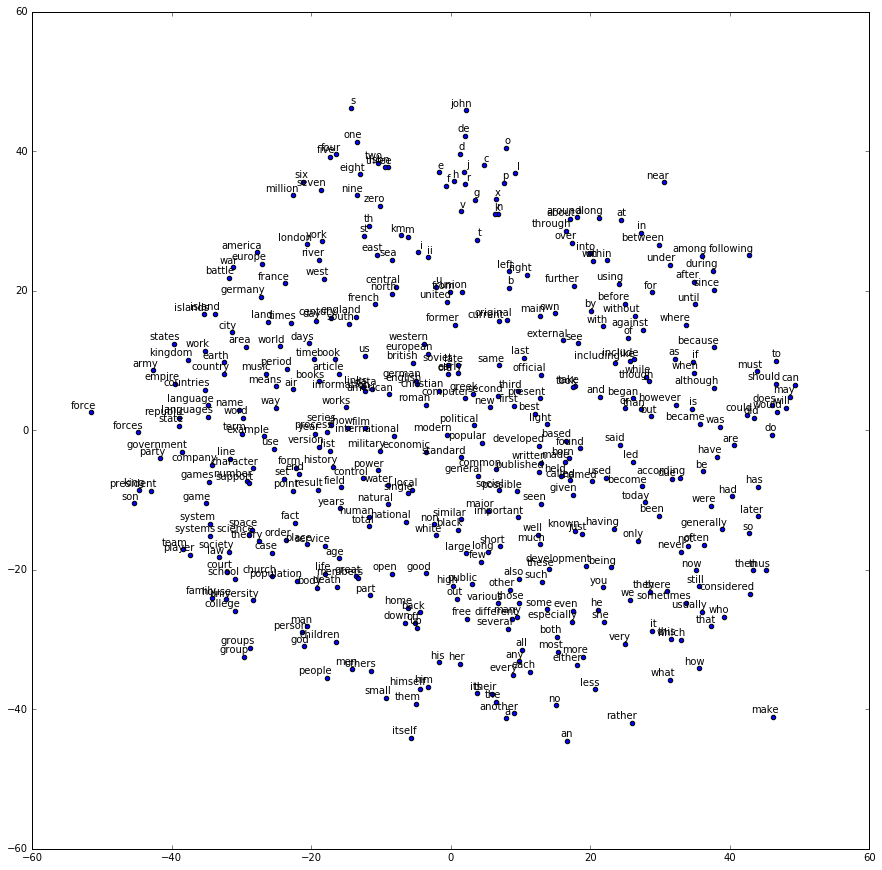

In [127]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()
        
words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)
        

In [128]:
puppy_emb = final_embeddings[dictionary['puppy']]
cat_emb = final_embeddings[dictionary['cat']]
dog_emb = final_embeddings[dictionary['dog']]
maybe_kitty_emb = puppy_emb - dog_emb + cat_emb

In [129]:
def cosine(v1, v2):
    v1 = v1 / np.sqrt(np.sum(np.power(v1,2)))
    v2 = v2 / np.sqrt(np.sum(np.power(v2,2)))
    return np.dot(v1, v2)

In [130]:
cosine([0,1], [0,2])

1.0

In [131]:
def cosine_on_puppy(other):
    return cosine(maybe_puppy_emb, other)

In [102]:
vec_cosine_to_puppy = np.vectorize(cosine_on_puppy)

In [103]:
norm_puppy = maybe_puppy_emb / np.sqrt(np.sum(np.power(maybe_puppy_emb, 2)))
norm_emb = final_embeddings / np.sqrt(np.sum(np.power(final_embeddings, 2), axis=1, keepdims=True))
dist_to_puppy = np.dot(norm_puppy, norm_emb.T)

In [104]:
dist_to_puppy = np.abs(dist_to_puppy)

In [132]:
norm_kitty = maybe_kitty_emb / np.sqrt(np.sum(np.power(maybe_kitty_emb, 2)))
norm_emb = final_embeddings / np.sqrt(np.sum(np.power(final_embeddings, 2), axis=1, keepdims=True))
dist_to_kitty = np.dot(norm_kitty, norm_emb.T)

In [133]:
dist_to_kitty = np.abs(dist_to_kitty)

In [134]:
argsorted = dist_to_kitty.argsort()

In [135]:
reverse_dictionary[argsorted[0]]

'sold'

In [136]:
for ind in argsorted[-10:]:
    print(reverse_dictionary[ind])

oberon
bose
brace
imf
chekhov
acquired
neutron
cat
dog
puppy


In [137]:
for ind in argsorted[:10]:
    print(reverse_dictionary[ind])

sold
reid
dore
sky
marlborough
materiality
unconcerned
sprinkled
accordingly
virus


In [80]:
dist_to_puppy[dictionary['puppy']]

-0.016428081

In [81]:
dist_to_puppy[dictionary['cat']]

-0.47352576

In [82]:
dist_to_puppy[dictionary['transmits']]

-9.7602606e-07

In [83]:
dist_to_puppy[dictionary['kitten']]

0.67861152

In [43]:
scores

array([ 4.09398127,  3.78560519,  4.13648033, ...,  4.05076408,
        4.73414087,  4.06764412], dtype=float32)

In [14]:
final_embeddings

array([[ 0.05019445,  0.10830101,  0.06165855, ...,  0.20556322,
         0.043656  ,  0.01605714],
       [ 0.1630692 , -0.02753918, -0.07456326, ...,  0.01527967,
        -0.15414621, -0.12536529],
       [-0.02903574,  0.01211464, -0.02095838, ..., -0.05312009,
         0.09218076, -0.07679307],
       ..., 
       [ 0.08162697, -0.07712698, -0.05894171, ...,  0.07087699,
        -0.14965883,  0.07014252],
       [ 0.11172617,  0.05531071,  0.13687937, ...,  0.0503158 ,
        -0.08740673,  0.0074301 ],
       [-0.07807975, -0.11759619, -0.00961178, ...,  0.07627473,
        -0.09609273,  0.00632166]], dtype=float32)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [149]:
type(data)

list

In [153]:
data_index = 0

def generate_cbow_batch(batch_size, context_size):
    """
    batch_size: self evident
    context_size: # of words to the left to include, (same number to the right)
    """
    global data_index
#     assert batch_size % num_skips == 0
#     assert num_skips <= 2 * skip_window
    assert data_index >= context_size
#     assert data_index + batch_size + context_size <= len(data)
    
    batch = np.ndarray(shape=(batch_size, context_size*2), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
#     span = 2 * context_size + 1 # [ skip_window target skip_window ]
#     buffer = collections.deque(maxlen=span)
    for i in range(batch_size):
        batch[i, :] = data[data_index-context_size:data_index]+\
                      data[data_index+1:data_index+1+context_size]
        labels[i, 0] = data[data_index]
        data_index += 1
        if len(data) - context_size <= data_index:
            data_index = context_size
    return batch, labels
            
print('data:', [reverse_dictionary[di] for di in data[:8]])

for context_size in [1, 3]:
    data_index = context_size
    batch, labels = generate_cbow_batch(batch_size=3, context_size=context_size)
    print('\nwith context_size = %d:' % (context_size))
    print('    batch:', [[reverse_dictionary[bi] for bi in batch_in] for batch_in in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(3)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with context_size = 1:
    batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term']]
    labels: ['originated', 'as', 'a']

with context_size = 3:
    batch: [['anarchism', 'originated', 'as', 'term', 'of', 'abuse'], ['originated', 'as', 'a', 'of', 'abuse', 'first'], ['as', 'a', 'term', 'abuse', 'first', 'used']]
    labels: ['a', 'term', 'of']


In [184]:
batch_size = 128
embedding_size = 128 
valid_size = 16 
valid_window = 100 
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 
context_size = 4

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, 2*context_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # Variables.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    # Model.
    # Look up embeddings for inputs and average the embeddings.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    avg_embed = tf.reduce_mean(embed, axis=1)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, avg_embed,
                                   train_labels, num_sampled=1, num_classes=vocabulary_size))
    
    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.RMSPropOptimizer(1.0).minimize(loss)
    
    
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [185]:
num_steps = 1000001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
#     step = 0
    data_index = context_size
    for step in range(num_steps):
        batch_data, batch_labels = generate_cbow_batch(batch_size, context_size)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
                # The average loss is an estimate of the loss over the last 2000 batches.
                print('Average loss at step %d: %f' % (step, average_loss))
                average_loss = 0
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                if step % 10000 == 0:
                    sim = similarity.eval()
                    for i in range(valid_size):
                        valid_word = reverse_dictionary[valid_examples[i]]
                        top_k = 8 # number of nearest neighbors
                        nearest = (-sim[i, :]).argsort()[1:top_k+1]
                        log = 'Nearest to %s:' % valid_word
                        for k in range(top_k):
                            close_word = reverse_dictionary[nearest[k]]
                            log = '%s %s,' % (log, close_word)
                        print(log)
                    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 2000: 3076.101213
Average loss at step 4000: 3244.583801
Average loss at step 6000: 4278.972923
Average loss at step 8000: 4360.414080
Average loss at step 10000: 4696.602498
Nearest to more: altitudes, less, accumulated, shallow, yster, geologists, rabbah, stormed,
Nearest to often: insignia, locke, perhaps, retain, dynastic, examples, rupert, rebellions,
Nearest to no: consequences, excess, julio, sikhs, babylonia, gorgias, admit, any,
Nearest to of: regrouped, endowed, marker, blog, dancing, outsiders, opposes, cavour,
Nearest to three: steals, steiner, plaintext, hindustan, conciliator, ligatures, aud, migrating,
Nearest to on: thanksgiving, saudis, intelligible, brennan, boehm, bacillus, reasonable, stigma,
Nearest to be: reach, pray, charset, defend, referred, gospel, reliably, guaranteed,
Nearest to it: said, cycles, rendered, wwe, transliterated, stile, recognised, conventionally,
Nearest to was: intermediate, unfortunate, severed, cyborg, hath,

In [160]:
final_embeddings

array([[ 0.0123028 ,  0.02313535, -0.02995043, ..., -0.02341195,
        -0.05718267,  0.03409408],
       [-0.03498375,  0.02013979,  0.01809659, ..., -0.0467014 ,
         0.11775357, -0.05048613],
       [ 0.05635405,  0.11304981,  0.05451286, ...,  0.12096646,
         0.07448185,  0.03099874],
       ..., 
       [ 0.06338844,  0.1297698 ,  0.14581573, ...,  0.07332782,
        -0.05866871, -0.038891  ],
       [-0.01535533,  0.02781129, -0.11959556, ..., -0.15540422,
         0.01484907, -0.09153182],
       [-0.00754737,  0.12947156,  0.04356332, ..., -0.05809375,
         0.0645621 , -0.00545153]], dtype=float32)

In [161]:
puppy_emb = final_embeddings[dictionary['puppy']]
cat_emb = final_embeddings[dictionary['cat']]
dog_emb = final_embeddings[dictionary['dog']]
maybe_kitty_emb = puppy_emb - dog_emb + cat_emb

In [162]:
def cosine(v1, v2):
    v1 = v1 / np.sqrt(np.sum(np.power(v1,2)))
    v2 = v2 / np.sqrt(np.sum(np.power(v2,2)))
    return np.dot(v1, v2)

In [164]:
norm_kitty = maybe_kitty_emb / np.sqrt(np.sum(np.power(maybe_kitty_emb, 2)))
norm_emb = final_embeddings / np.sqrt(np.sum(np.power(final_embeddings, 2), axis=1, keepdims=True))
dist_to_kitty = np.dot(norm_kitty, norm_emb.T)

In [165]:
dist_to_kitty = np.abs(dist_to_kitty)

In [166]:
argsorted = dist_to_kitty.argsort()

In [168]:
reverse_dictionary[argsorted[-1]]

'puppy'

In [177]:
for ind in argsorted[-20:]:
    print(reverse_dictionary[ind], dist_to_kitty[ind])

capp 0.309485
ragnarok 0.310321
mesolithic 0.310582
chalcedonian 0.311138
eisenach 0.311797
improperly 0.31337
monopolize 0.317065
ackermann 0.325848
woensel 0.326484
automorphism 0.32822
privateer 0.331616
machado 0.334702
analytical 0.336557
pipers 0.336704
thom 0.351162
gratis 0.360004
groton 0.368995
cat 0.382915
dog 0.425799
puppy 0.643535


In [170]:
for ind in argsorted[:10]:
    print(reverse_dictionary[ind])

speller
eager
cigarettes
compounds
stove
warrior
toxin
atheists
awt
iia


In [178]:
dist_to_kitty[dictionary['puppy']]

0.64353466

In [179]:
dist_to_kitty[dictionary['cat']]

0.38291526

In [180]:
dist_to_kitty[dictionary['kitten']]

0.023858272

In [181]:
dist_to_kitty[dictionary['kitty']]

0.002347488